In [3]:
# importing libraries.......
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

In [4]:
# Loading parameters and dataset
platform = "PC"

if platform != "PC":
    
    #import libraries for led blinking
    from gpiozero import LED

    # Defining three LEDs
    dataLED = LED(23)
    attackLED = LED(24)
    detectionLED = LED(25)


# Defining IDs and number of associated signals
list_of_ids = list(range(1, 11))
num_of_id = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4]
num_sigs_per_id = {}
for can_id, n_id in zip(list_of_ids, num_of_id):
    num_sigs_per_id[can_id] = n_id


# #Loading Raw Data Frame
folder_dir = 'SynCAN Data Cut/'
target_file = "test_flooding"
data_dir = folder_dir+target_file+'_cut.csv'

with open(data_dir,'r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
df_raw = pd.DataFrame(data)
df_raw.columns = ['Label', 'Time', 'ID','Signal1', 'Signal2', 'Signal3', 'Signal4']
df_raw = df_raw.drop(0)

FileNotFoundError: [Errno 2] No such file or directory: 'SynCAN Data Cut/test_flooding_cut.csv'

In [3]:
# collected signals...
signals_in_cluster = ['Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_6',
 'Sig_1_of_ID_8',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_3_of_ID_10',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_2',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9']

In [6]:
time_data = []

In [7]:
dataset = 'syncan'

In [8]:
for model_type in ['Original', 'Lite']:
    for w in [20, 50, 100]:
    # for w in [25]:
        # Design hyper-parameters....
        T_xs = [1]
        q = max(T_xs)*w
        n = len(signals_in_cluster)

        # Loading autoencoders....
        autoencoders = {}
        interpreters = {}

        for T_x in T_xs:

            if model_type =='Orignial':
                filename = f'framework/models/original_models//Autoencoder_Final_{w}_1_{T_x}_True.h5'
                autoencoders[T_x] = load_model(filename)
            else:
                # Converting saved model to a TensorFlow Lite model.
                filename = f'framework/models/lite_models//Autoencoder_Final_{w}_1_{T_x}_True'
                converter = tf.lite.TFLiteConverter.from_saved_model(filename)
                tflite_model = converter.convert()
                # Set interpreter...
                interpreters[T_x] = tf.lite.Interpreter(model_content=tflite_model)
                


        #Setting up thresholds....
        R_loss = np.random.rand(n)
        R_time = (np.random.rand(n)*n).astype(int)
        R_signal = np.random.randint(n)


        # Initiating the dataQ
        dataQ = pd.DataFrame(np.zeros((q, n), dtype = float), columns = signals_in_cluster)
        dataQ.index = dataQ.index + 1

        print("Initiating analysis.... ", w)
        for index, data in enumerate(df_raw.values):   

            begin_time = datetime.datetime.now()
            #Reading data from the CAN bus in decoded foramt
            can_id = int(data[2][2:])
            signals_reported = [f'Sig_{i+1}_of_ID_{can_id}' for i in range(num_sigs_per_id[can_id])]
            signals_missing = set(signals_in_cluster) - set(signals_reported)

            # Updating dataQ    
            new_data = [float(x) for x in data[3:3+num_sigs_per_id[can_id]]].copy()
            dataQ.loc[2:q] = dataQ.loc[1:q-1].values.copy()
            dataQ.loc[1, signals_reported] = new_data.copy()
            dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
            time_elapsed = datetime.datetime.now() - begin_time
            time_needed_dataQ = float(time_elapsed.total_seconds())


            #Creating different views and predicting reconstrcuted image
            anomaly_S_ens = 0
        #     prediction_time = 0
        #     analysis_time = 0


            for T_x in T_xs:       

                prediction_time = 0
                analysis_time = 0

                # Creating different views.....
                #starting timer

                
                dataV_org = dataQ.loc[1:(w*T_x):T_x].values.reshape(1, w, n, 1).copy()
                
                if model_type != 'Original':
                    dataV_org = np.array(dataV_org.values, dtype=np.float32)

                begin_time = datetime.datetime.now()

                # Predict.....
                if model_type == 'Original':
                    dataV_recon = autoencoders[T_x].predict(dataV_org)
                
                else:
                    interpreter = interpreters[T_x]
                    interpreter.allocate_tensors() 
                    #get input and output tensors
                    input_details = interpreter.get_input_details()
                    output_details = interpreter.get_output_details()

                    #set the tensor to point to the input data to be inferred
                    input_index = input_details[0]["index"]
                    interpreter.set_tensor(input_index, dataV_recon)
                    #Run the inference
                    interpreter.invoke()
                    output_details = interpreter.get_output_details()
                    # Output
                    dataV_recon = interpreter.get_tensor(output_details[0]['index'])
                    

                        

                #stopping timer
                time_elapsed = datetime.datetime.now() - begin_time
                prediction_time += float(time_elapsed.total_seconds())
                
    #             dataV_recon = dataV_recon[0,:,:,0].copy()

                #starting timer
                begin_time = datetime.datetime.now()

                dataV_loss = abs(dataV_org - dataV_recon)[0,:,:,0].copy()
                #finding anomaly scores for individual models...
                anomaly_B = (dataV_loss > R_loss).astype(int)
                anomaly_C = np.sum(anomaly_B,0)
                anomaly_S = np.sum(anomaly_C > R_time)
                anomaly_S_ens += anomaly_S

                #stopping timer
                time_elapsed = datetime.datetime.now() - begin_time
                analysis_time  += float(time_elapsed.total_seconds())

                time_data.append([w, T_x, time_needed_dataQ, prediction_time, analysis_time, model_type])



        #         if anomaly_S > R_signal:
        #             predictions[T_x].append(1)
        #         else:
        #             predictions[T_x].append(0)    


            # Checking the final ensemble score..
        #     if anomaly_S_ens > R_signal_ens:
        #         predictions['Ens'].append(1)
        #     else:
        #         predictions['Ens'].append(0)   

        #     time_data.append([w, T_x, time_needed_dataQ, prediction_time, analysis_time])

            if index == 100:
                break

Initiating analysis....  25


In [9]:
time_df = pd.DataFrame(time_data, columns = ['w', 'Tx', 'Data Queue', 'Prediction', 'Analysis'])

In [10]:
time_df.to_csv('time_df.csv', header = True, index = True)

<AxesSubplot:xlabel='w', ylabel='Prediction'>

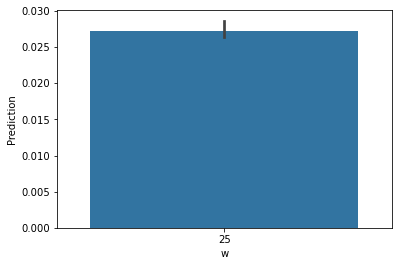

In [11]:
import seaborn as sns
sns.barplot(data = time_df, x = 'w', y = 'Prediction')
# sns.barplot(data = time_df, x = 'w', y = 'Data Queue')
# sns.barplot(data = time_df, x = 'w', y = 'Analysis')

In [12]:
autoencoders[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 29, 24, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 29, 24, 16)        272       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 29, 24, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 12, 8)         1160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 12, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 6, 8)           0

In [21]:
df_raw['Time'] = df_raw['Time'].astype(float)

df_raw['Time'][0:100].iloc[0] - df_raw['Time'][0:100].iloc[-1]

-208.29669998586178

In [19]:
df_raw['Time'][0:100][1]

81008449.4467